In [1]:
!pip install --user --upgrade tensorflow-probability
!pip install observations

    100% |████████████████████████████████| 460kB 21.2MB/s 
    100% |████████████████████████████████| 491kB 19.6MB/s 
  Running setup.py bdist_wheel for observations ... - \ | / - \ | / - \ done
  Stored in directory: /content/.cache/pip/wheels/21/53/d7/c4d7a5cab86d07b083ebb2e417dcd0cb2bf5dd8c440af675d7
Successfully built observations


In [115]:
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed

from observations import iris, mnist
DATA_DIR = './data'


%matplotlib inline

seed = 2018
np.random.seed(seed)
tf.set_random_seed(seed)

In [108]:
(x_train, y_train), (x_test, y_test) = mnist(DATA_DIR)
N = 1999
x_train = x_train[:N].T
y_class = y_train[:N]
print(x_train.shape, len(y_class))

data_dim, num_datapoints = x_train.shape
latent_dim = 2
stddv_datapoints = 0.5

(784, 1999) 1999


In [118]:
x_train, y_train, _ = iris(DATA_DIR)
x_train = x_train.T
y_labels = np.unique(y_train)
y_label_map = dict((label, i) for i, label in enumerate(y_labels))
y_class = list(map(lambda label: y_label_map[label] , y_train))

print(x_train.shape, len(y_train))

data_dim, num_datapoints = x_train.shape
latent_dim = 2
stddv_datapoints = 0.5

(4, 150) 150


In [119]:
def ppca_model(data_dim, latent_dim, num_datapoints, stddv_datapoints, n_fixed, zf):
    w = ed.Normal(loc=tf.zeros([data_dim, latent_dim]),
                  scale=tf.ones([data_dim, latent_dim]),
                  name="w")
#     z = ed.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
#                   scale=tf.ones([latent_dim, num_datapoints]),
#                   name="z")
    zd = ed.Normal(loc=tf.zeros([latent_dim, num_datapoints - n_fixed]),
                  scale=tf.ones([latent_dim, num_datapoints - n_fixed]),
                  name="zd")
    
    x = ed.Normal(loc= tf.concat([tf.matmul(w, zd), tf.matmul(w, zf)], axis=1),
                  scale=stddv_datapoints * tf.ones([data_dim, num_datapoints]),
                  name="x")
    return x, (w, zd)

log_joint = ed.make_log_joint_fn(ppca_model)

In [120]:
def train_map(x_train, num_epochs, list_fixed=[]):
    # first, define `w` and `z` as variable in the model

    tf.reset_default_graph()

    w = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
    z = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)

    # second, define a target function, which is an "unnormalized target density".
    # as a function of the parameters `w`, `z`
    # Note that we want to maximize the posterior distr.
    # which is proportional to the joint distribution of the model
    # -> the target function to maximize is exactly the joint distr. function
    def target(w, z):
        return log_joint(data_dim=data_dim,
                latent_dim=latent_dim,
                num_datapoints=num_datapoints,
                stddv_datapoints=stddv_datapoints,
                w=w, z=z, x=x_train)

    # third, define the "energy function", which is the opposite of target function
    # we will use the off-the-shelf optimization module which minimize an objective function
    # that's why we conver the maximization prob. to mizimization one
    energy = - target(w, z)

    optimizer = tf.train.AdamOptimizer(learning_rate=0.05)
    train = optimizer.minimize(energy)

    # Learning params === Infering
    init = tf.global_variables_initializer()
    losses = []

    with tf.Session() as sess:
        # init all variables
        sess.run(init)

        # start to train
        for i in range(num_epochs):
            sess.run(train)

            if i % 5 == 0:
                # get snapshot of the current values of function and vars
                cE, cw, cz = sess.run([energy, w, z])
                losses.append(cE)

        # when finishing the training, get the learned values of the variables
        w_map = sess.run(w)
        z_mean_map = sess.run(z)


    return losses, z_mean_map

In [121]:
def train(x_train, num_epochs = 1000, list_fixed=[]):
    # because we've run the computational graph of TF once,
    # before continuing to run the TF code, we MUST reset the computational graph
    tf.reset_default_graph()
    
    n_fixed = len(list_fixed)
    print('Fixed point: ', list_fixed)
    
    # create fixe dist. for list_fixed points
    if n_fixed == 0:
        zf = ed.Normal(
            loc=tf.zeros([latent_dim, n_fixed]),
            scale=tf.ones([latent_dim, n_fixed]),
            name='zf'
        )
    else:
        zf = ed.Normal(
            loc=list_fixed.T,
            scale=0.1,
            name='zf'
        )
      
    # define how to calculate the energy
    complete_log_joint = ed.make_log_joint_fn(ppca_model)
    def target(_w, _zd):
        return complete_log_joint(data_dim=data_dim,
            latent_dim=latent_dim,
            num_datapoints=num_datapoints,
            stddv_datapoints=stddv_datapoints,
            n_fixed=n_fixed, zf=zf,
            w=_w, zd=_zd, x=x_train)
    
    # define the variables for W and Z (note to specify the default values for them)
    w = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
    zd = tf.Variable(np.ones([latent_dim, num_datapoints - n_fixed]), dtype=tf.float32)
    energy = - target(w, zd)
    
    # define how to maximize the complete log likelihood
    optimizer = tf.train.AdamOptimizer(learning_rate=0.05)
    train_process = optimizer.minimize(energy)

    init_process = tf.global_variables_initializer()
    losses = []

    with tf.Session() as sess:
        # first, make sure to init all varaibles
        sess.run(init_process)

        # then run the training process
        for i in range(num_epochs):
            sess.run(train_process)

            # log the value of energy
            if i % 5 == 0:
                loss = sess.run([energy])
                losses.append(loss)

        # after finishing the training, make sure to collect the target parameters
        w_map = sess.run(w)
        z_mean = sess.run(zd)
        
    return losses, w_map, z_mean

In [122]:
from matplotlib import cm
from matplotlib import patches


def viz(z_mean, y_class, num_datapoints, list_fixed):
    n_fixed = len(list_fixed)    
    fig, ax = plt.subplots(figsize=(12,12))
    ax.scatter(z_mean[0, :], z_mean[1, :], s=4,
               c=y_class[:num_datapoints-n_fixed], cmap=cm.tab10, alpha=1.0)
    for x, y in list_fixed:
        ax.plot([x], [y], marker='*', markersize=20, color='red')
    plt.show()
    
    
def viz_diff(z_mean0, z_mean1, y_class, num_datapoints, list_fixed0, list_fixed1):
    n_fixed = len(list_fixed)
    fig, ax = plt.subplots(figsize=(12,12))
    plt.axis([-5, 20, -5, 20])

    for i in range(num_datapoints - n_fixed):
        x1, y1 = z_mean0[:, i]
        x2, y2 = z_mean1[:, i]
        ax.arrow(x1, y1, x2-x1, y2-y1, color=cm.tab10(y_class[i]), shape='full', lw=0.8, length_includes_head=True, head_width=.1)
      
    for j in range(n_fixed):
        x1, y1 = list_fixed0[j]
        x2, y2 = list_fixed1[j]
        j_class = y_class[num_datapoints - n_fixed + j]
        print("Move point {} (class {} ) from {} to {}".format(j+1, j_class, (x1, y1), (x2, y2)))
        
        ax.arrow(x1, y1, x2-x1, y2-y1, color=cm.tab10(j_class), shape='full', lw=0.8, length_includes_head=True, head_width=.1)
        ax.plot([x2], [y2], marker='*', markersize=20, color=cm.tab10(j_class))

    plt.show()    

Fixed point:  []


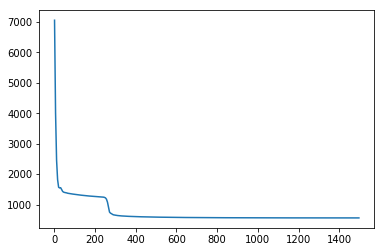

In [132]:
num_epochs = 1500
list_fixed0=[]
losses, w_map0, z_mean0 = train(x_train, num_epochs, list_fixed0)

plt.plot(range(1, num_epochs, 5), losses)
plt.show()

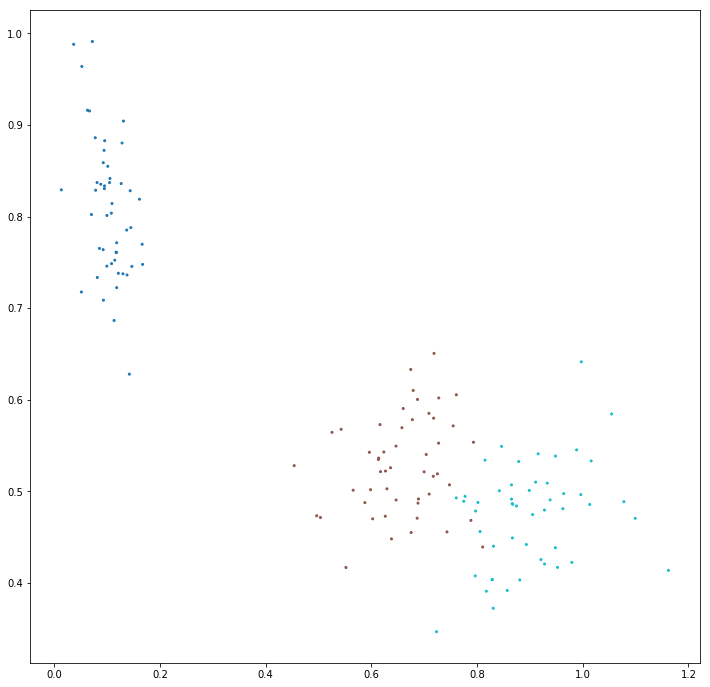

In [133]:
viz(z_mean0, y_class, num_datapoints, [])

Fixed point:  [[ 2.  0.]
 [ 4. -2.]]


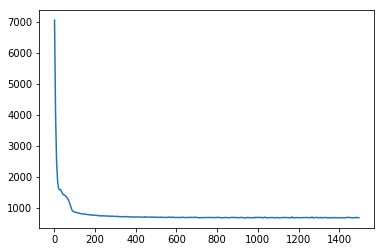

In [134]:
num_epochs = 1500
# list_fixed1=np.array([ [10., 5.], [5., 10.] ], dtype=np.float32)
list_fixed1=np.array([ [2., 0.], [4., -2.] ], dtype=np.float32)
losses, w_map1, z_mean1 = train(x_train, num_epochs, list_fixed1)

plt.plot(range(1, num_epochs, 5), losses)
plt.show()

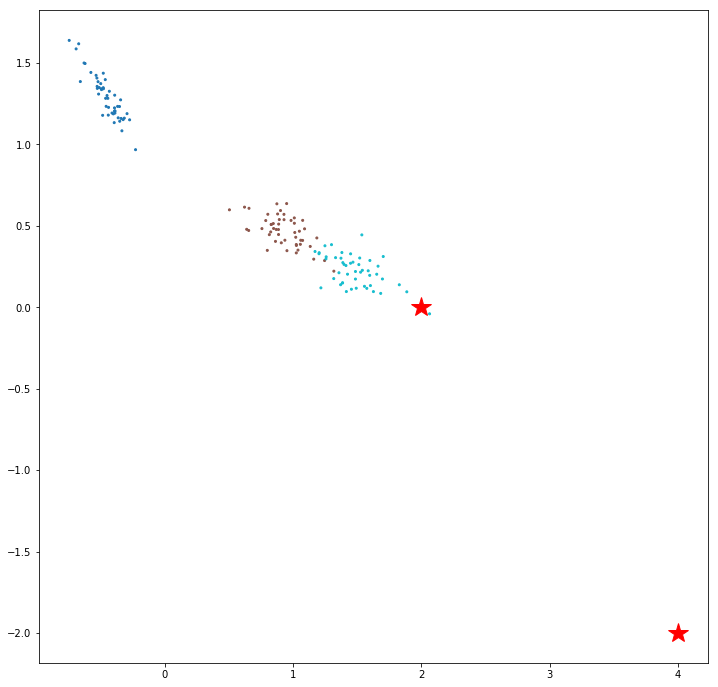

[[0.8664002418518066, 0.48665469884872437], [0.8056146502494812, 0.45623600482940674]]
Move point 1 (class 2 ) from (0.8664002418518066, 0.48665469884872437) to (2.0, 0.0)
Move point 2 (class 2 ) from (0.8056146502494812, 0.45623600482940674) to (4.0, -2.0)


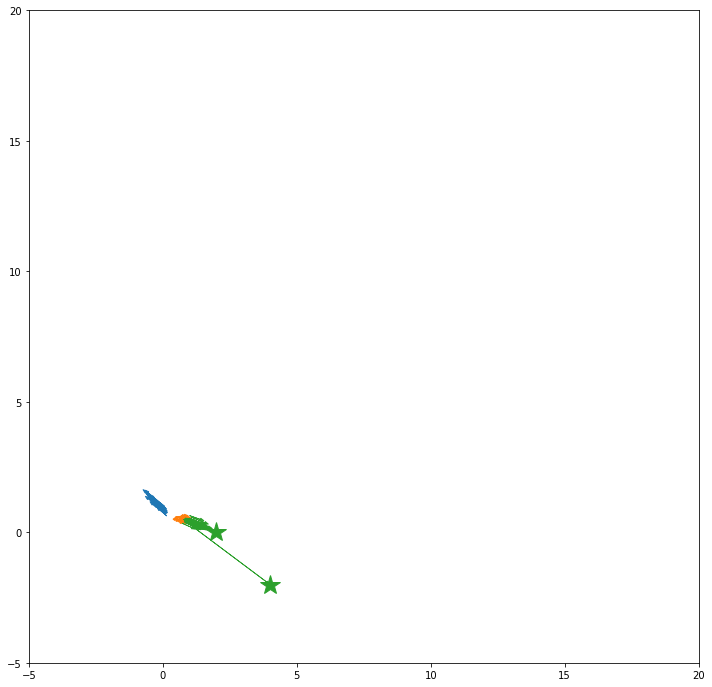

In [136]:
viz(z_mean1, y_class, num_datapoints, list_fixed1)
list_fixed0 = z_mean0[:,-2:].T.tolist()
print(list_fixed0)
viz_diff(z_mean0, z_mean1, y_class, num_datapoints, list_fixed0 , list_fixed1)

Fixed point:  [[15.  0.]
 [ 0. 15.]]


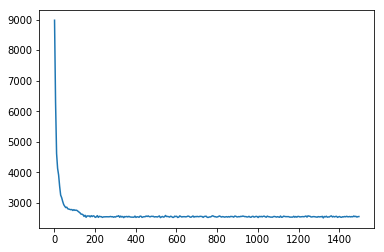

In [127]:
num_epochs = 1500
list_fixed2=np.array([ [15., 0.], [0., 15.] ], dtype=np.float32)
losses, w_map2, z_mean2 = train(x_train, num_epochs, list_fixed2)

plt.plot(range(1, num_epochs, 5), losses)
plt.show()

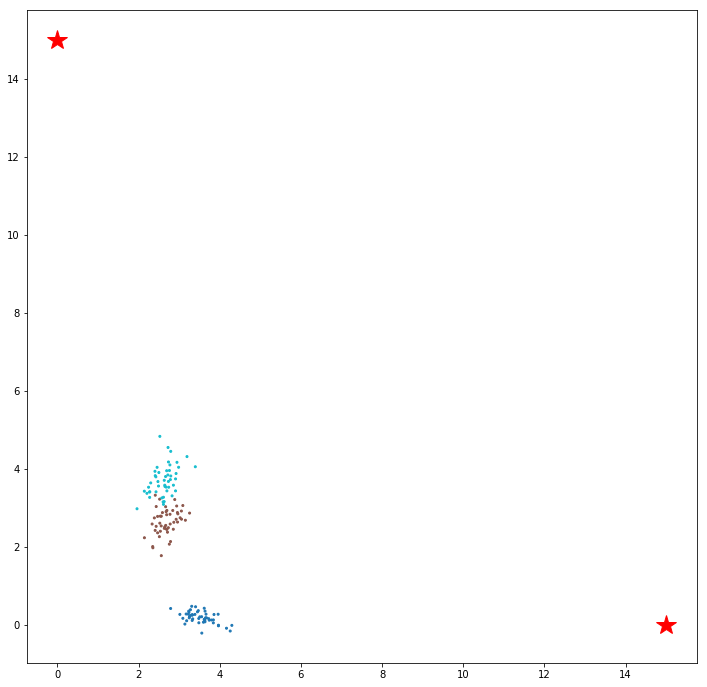

Move point 1 (class 2 ) from (0.8664002418518066, 0.48665469884872437) to (15.0, 0.0)
Move point 2 (class 2 ) from (0.8056146502494812, 0.45623600482940674) to (0.0, 15.0)


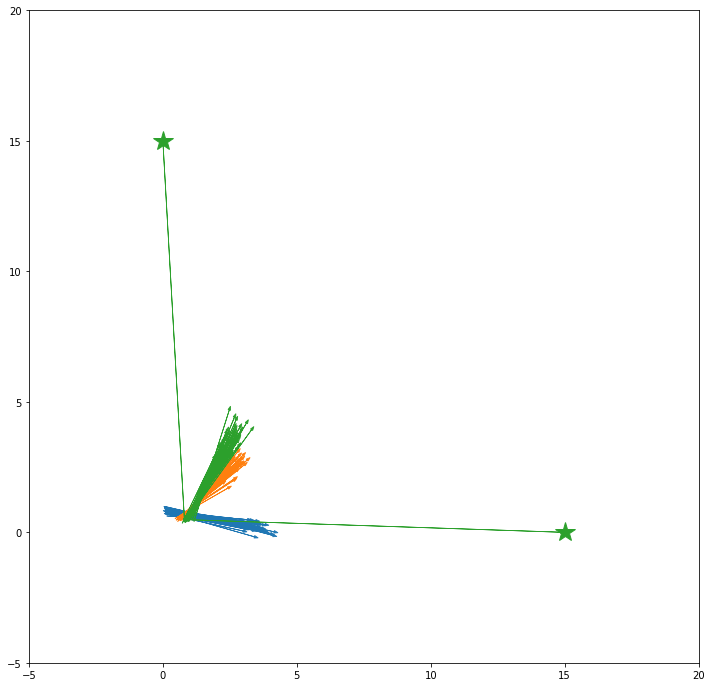

Move point 1 (class 2 ) from (10.0, 5.0) to (15.0, 0.0)
Move point 2 (class 2 ) from (5.0, 10.0) to (0.0, 15.0)


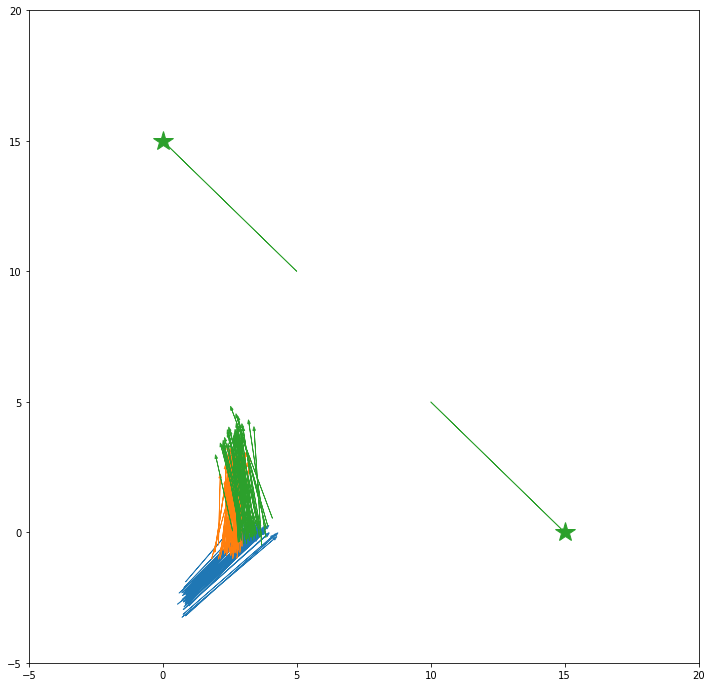

In [128]:
viz(z_mean2, y_class, num_datapoints, list_fixed2)

viz_diff(z_mean0, z_mean2, y_class, num_datapoints, list_fixed0, list_fixed2)

viz_diff(z_mean1, z_mean2, y_class, num_datapoints, list_fixed1, list_fixed2)

In [0]:
# try to change somethings
def replace_latents(z_mean, z_stddv):
    def interceptor(rv_constructor, *rv_args, **rv_kwargs):
        """Replaces the priors with the calculated priors"""
        name = rv_kwargs.pop("name")
        if name == "qzd":
          rv_kwargs["loc"] = z_mean
          rv_kwargs["scale"] = z_stddv
          print("QZD replaced: ", rv_kwargs)
        return rv_constructor(*rv_args, **rv_kwargs)
    return interceptor

In [0]:
num_epochs = 3000
list_fixed=np.array([ [0., 0.]], dtype=np.float32)
n_fixed = len(list_fixed)
old_z_mean = z_mean_vi[:,:-n_fixed]    
old_z_stddv = z_stddv_vi[:, :-n_fixed]

with ed.interception(replace_latents(old_z_mean, old_z_stddv)):
    losses, (w_mean_vi, w_stddv_vi), (new_z_mean_vi, new_z_stddv_vi) = train(x_train, num_epochs, list_fixed)

plt.plot(range(1, num_epochs, 5), losses)
plt.show()

viz(new_z_mean_vi, new_z_stddv_vi, y_class, num_datapoints, list_fixed)